# Monte Carlo Simulations for PIA

TODO:

- change T2 range for stability

## Required Libraries 

In [4]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from typing import List
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import time
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from IPython import display
from scipy.stats import pearsonr

## Define PIA Model

In [2]:
class PIA(nn.Module):

    def __init__(self,
                number_of_signals=16,
                D_mean = [0.5, 1.2, 2.85],
                T2_mean = [45, 70, 750],
                D_delta = [0.2, 0.5, 0.15],
                T2_delta = [25, 30, 250],
                b_values = [0, 150, 1000, 1500],
                TE_values = [0, 13, 93, 143],
                hidden_dims: List = None,
                predictor_depth=1):
        super(PIA, self).__init__()

        #device = 'cuda' if torch.cuda.is_available() else 'cpu'
        device = 'cuda'
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]
        
        self.number_of_signals = number_of_signals
        self.number_of_compartments = 3
        self.D_mean = torch.from_numpy(np.asarray(D_mean)).to(device)
        self.T2_mean = torch.from_numpy(np.asarray(T2_mean)).to(device)
        self.D_delta = torch.from_numpy(np.asarray(D_delta)).to(device)
        self.T2_delta = torch.from_numpy(np.asarray(T2_delta)).to(device)
        self.b_values = b_values
        self.TE_values = TE_values
        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = nn.ReLU()


        

        modules = []
        # Build Encoder
        in_channels = number_of_signals
        for h_dim in hidden_dims:
            
            modules.append(
                nn.Sequential(
                    nn.Linear(in_features=in_channels, out_features=h_dim),
                    #nn.Dropout(p=0.2),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules).to(device)

        D_predictor = []
        for _ in range(predictor_depth):
            
            D_predictor.append(
                nn.Sequential(
                    nn.Linear(in_features=hidden_dims[-1], out_features=hidden_dims[-1]),
                    nn.LeakyReLU())
            )
        D_predictor.append(nn.Linear(hidden_dims[-1], self.number_of_compartments))
        self.D_predictor = nn.Sequential(*D_predictor).to(device)


        T2_predictor = []
        for _ in range(predictor_depth):
            
            T2_predictor.append(
                nn.Sequential(
                    nn.Linear(in_features=hidden_dims[-1], out_features=hidden_dims[-1]),
                    nn.LeakyReLU())
            )
        T2_predictor.append(nn.Linear(hidden_dims[-1], self.number_of_compartments))
        self.T2_predictor = nn.Sequential(*T2_predictor).to(device)

        v_predictor = []
        for _ in range(predictor_depth):
            
            v_predictor.append(
                nn.Sequential(
                    nn.Linear(in_features=hidden_dims[-1], out_features=hidden_dims[-1]),
                    nn.LeakyReLU())
            )
        v_predictor.append(nn.Linear(hidden_dims[-1], self.number_of_compartments))
        self.v_predictor = nn.Sequential(*v_predictor).to(device)
        


    def encode(self, x):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(x)
        
        D_var = self.D_delta*torch.tanh(self.D_predictor(result))
        T2_var = self.T2_delta*torch.tanh(self.T2_predictor(result))
        v = self.softmax(self.v_predictor(result))
        
        return [self.D_mean + D_var, self.T2_mean + T2_var, v]

    def decode(self, D, T2, v):
        """
            Maps the given latent codes onto the signal space.
            param D: [D_ep, D_st, D_lu]
            param T2: [T2_ep, T2_st, T2_lu]
            param v: [v_ep, v_st, v_lu]
            return: (Tensor) signal estimate
        """
        signal = torch.zeros((D.shape[0], self.number_of_signals))
        D, T2, v = D.T, T2.T, v.T
        ctr = 0
        for b in self.b_values:
            for TE in self.TE_values:
                S_ep = v[0]*torch.exp(-b/1000*D[0])*torch.exp(-TE/T2[0])
                S_st = v[1]*torch.exp(-b/1000*D[1])*torch.exp(-TE/T2[1])
                S_lu = v[2]*torch.exp(-b/1000*D[2])*torch.exp(-TE/T2[2])
                signal[:, ctr] = S_ep + S_st + S_lu
                ctr += 1
        return signal
    
    
    def forward(self, x):
        D, T2, v = self.encode(x)
        return  [self.decode(D, T2, v), x, D, T2, v]


    def loss_function(self, pred_signal, true_signal, PIDS):

        return torch.mean(PIDS * (pred_signal - true_signal) ** 2)
    


def get_batch(batch_size=16, noise_sdt=0.1):

    b_values = [0, 150, 1000, 1500]
    TE_values = [0, 13, 93, 143]

    b_TE = []
    for b in b_values:
        for TE in TE_values:
            b_TE.append((b,TE))
    
    D_ep = np.random.uniform(0.3, 0.7, batch_size)
    D_st = np.random.uniform(0.7, 1.7, batch_size)
    D_lu = np.random.uniform(2.7, 3, batch_size)
    T2_ep = np.random.uniform(20, 70, batch_size)
    T2_st = np.random.uniform(40, 100, batch_size)
    T2_lu = np.random.uniform(500, 1000, batch_size)
    
    v_ep = np.random.uniform(0, 1, batch_size)
    v_st = np.random.uniform(0, 1, batch_size)
    v_lu = np.random.uniform(0, 1, batch_size)
    
    sum_abc = v_ep + v_st + v_lu
    
    v_ep = v_ep/sum_abc
    v_st = v_st/sum_abc
    v_lu = v_lu/sum_abc
     

    signal = np.zeros((batch_size, len(b_TE)), dtype=np.float)
    for sample in range(batch_size):
        for ctr, (b, TE) in enumerate(b_TE):
            S_ep = v_ep[sample]*np.exp(-b/1000*D_ep[sample])*np.exp(-TE/T2_ep[sample])
            S_st = v_st[sample]*np.exp(-b/1000*D_st[sample])*np.exp(-TE/T2_st[sample])
            S_lu = v_lu[sample]*np.exp(-b/1000*D_lu[sample])*np.exp(-TE/T2_lu[sample])
            signal[sample, ctr] = S_ep + S_st + S_lu

    D = np.asarray([D_ep, D_st, D_lu])
    T2 = np.asarray([T2_ep, T2_st, T2_lu])
    v = np.asarray([np.asarray(v_ep), np.asarray(v_st), np.asarray(v_lu)])
    noise_im = np.random.normal(0, noise_sdt, signal.shape)
    noise_re = np.random.normal(0, noise_sdt, signal.shape)
    noisy = np.sqrt((signal + noise_im)**2 + (signal + noise_re)**2)/np.sqrt(2)
    
    return torch.from_numpy(noisy).float(),torch.from_numpy(D.T).float(), torch.from_numpy(T2.T).float(),\
torch.from_numpy(v.T).float(), torch.from_numpy(signal).float()


def three_compartment_fit(M, D_ep, D_st, D_lu, T2_ep,  T2_st, T2_lu, V_ep, V_st):
    """
    
    Three-compartment fit for Hybrid estimation
    
    """
    b, TE = M
    S_ep = V_ep*np.exp(-b/1000*D_ep)*np.exp(-TE/T2_ep)
    S_st = V_st*np.exp(-b/1000*D_st)*np.exp(-TE/T2_st)
    S_lu =(1 - V_ep - V_st)*np.exp(-b/1000*D_lu)*np.exp(-TE/T2_lu)
    
    return S_ep + S_st + S_lu

def hybrid_fit(signals):
    bvals = [0, 150, 1000, 1500]
    normTE = [0, 13, 93, 143]
    eps = 1e-7;
    numcols, acquisitions = signals.shape
    D = np.zeros((numcols, 3))
    T2 = np.zeros((numcols, 3))
    v = np.zeros((numcols, 3))
    for col in tqdm(range(numcols)):
        voxel = signals[col]
        X, Y = np.meshgrid(normTE, bvals)
        xdata = np.vstack((Y.ravel(), X.ravel()))
        ydata = voxel.ravel()
        try:
            fitdata_, _  = curve_fit(three_compartment_fit, 
                                       xdata,
                                       ydata,
                                       p0 = [0.55, 1.3, 2.8, 50,  70, 750, 0.3, 0.4],
                                       check_finite=True,
                                       bounds=([0.3, 0.7, 2.7, 20,  40, 500, 0, 0],
                                               [0.7,  1.7, 3.0, 70,  100, 1000,1, 1]),
                                      method='trf',
                                      maxfev=5000)
        except RuntimeError:
            fitdata_ = [0.55,  1.3, 2.8, 50,  70, 750, 0.3, 0.4]
        coeffs = fitdata_
        D[col, :] = coeffs[0:3]
        T2[col, :] = coeffs[3:6]
        v[col, 0:2] = coeffs[6:]
        v[col, 2]  = 1 - coeffs[6] - coeffs[7]
    return D, T2, v


In [34]:
test_tensor, D_test2, T2_test2, v_test, clean = get_batch(2500, noise_sdt=0.02)
test = test_tensor.detach().cpu().numpy()
start = time.time()
D, T2, v = hybrid_fit(test)
end = time.time()
print(f'Hybrid 1.0 takes {end - start} seconds')

100%|██████████| 2500/2500 [03:42<00:00, 11.25it/s]

Hybrid 1.0 takes 222.18930077552795 seconds


In [37]:


for r in range(3):
    if r==0:
        x_image, y_image = v_test, v
        title = ['V_ep', 'V st', 'V lu']
    elif r==1:
        x_image, y_image = D_test2, D
        title = ['D ep', 'D st', 'D lu']
    elif r==2:
        x_image, y_image = T2_test2, T2
        title = ['T2 ep', 'T2 st', 'T2 lu']
    for c in range(3):

        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c]

        corr = round(pearsonr(y, x)[0], 2)
        mae = np.mean(np.abs(y - x))
        bias = np.mean((y - x))
        std = np.std((y - x))
        print(f'{title[c]} {corr:.2f} {mae:.2f} {bias:.2f} {std:.2f}')
        


V_ep 0.67 0.12 -0.04 0.15
V st 0.65 0.13 0.05 0.16
V lu 0.97 0.04 -0.01 0.04
D ep 0.29 0.14 -0.04 0.17
D st 0.40 0.28 0.01 0.37
D lu 0.17 0.12 0.01 0.15
T2 ep 0.55 11.54 -1.21 15.94
T2 st 0.33 18.31 2.15 23.56
T2 lu 0.13 214.17 39.12 252.12


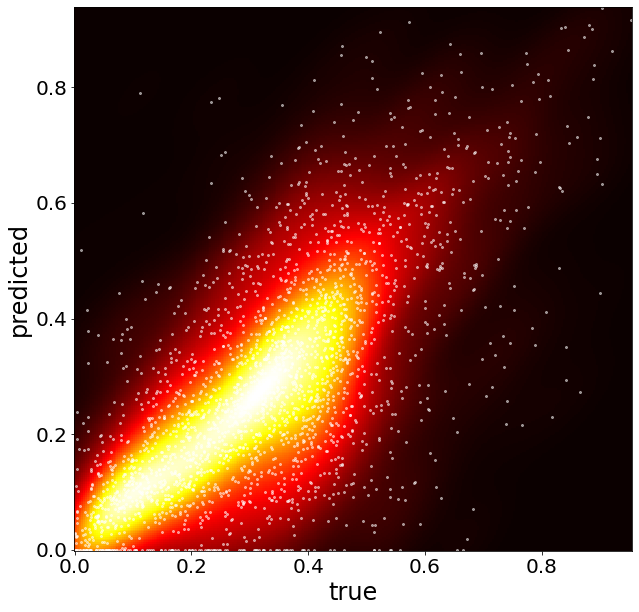

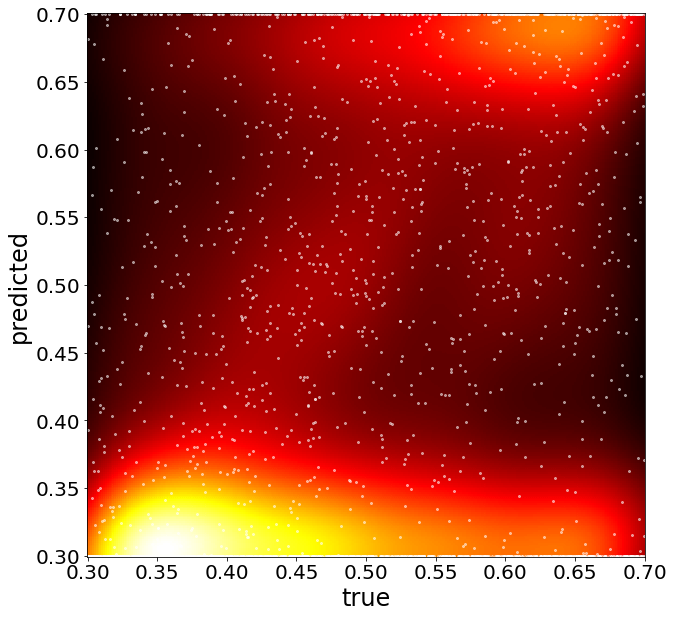

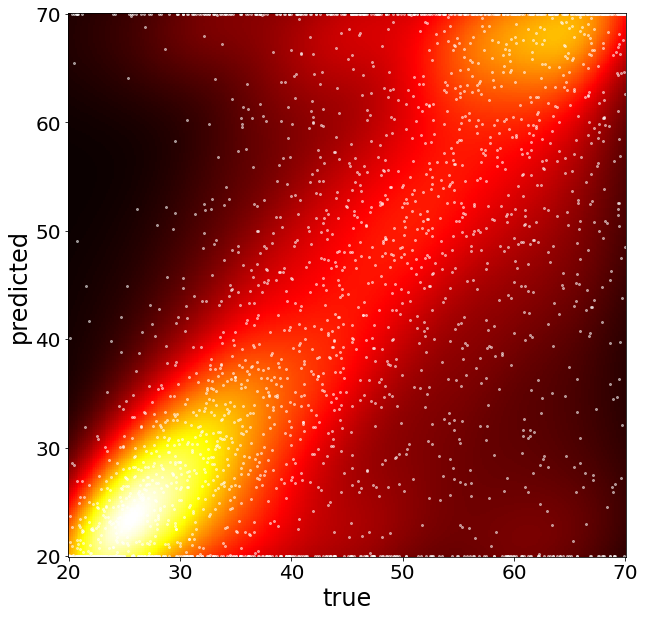

In [38]:
#fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    if r==0:
        x_image, y_image = v_test, v
        title = ['V_ep', 'V st', 'V lu']
        ylims = [(0,1), (0,1), (0,1)]
    elif r==1:
        x_image, y_image = D_test2, D
        title = ['D ep', 'D st', 'D lu']
        ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]
    elif r==2:
        x_image, y_image = T2_test2, T2
        title = ['T2 ep', 'T2 st', 'T2 lu']
        ylims = [(20, 70), (40, 100), (500, 1000)]
    for c in range(1):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c]
        nbins=300
        k = gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="hot", shading='auto')
        ax.scatter(x,y, color='white', s=4, alpha=0.5)

        err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image[:, c]))
        corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image[:, c])[0,1]
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        #ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
        ax.set_xlabel('true', fontsize=24)
        ax.set_ylabel('predicted', fontsize=24)


In [29]:
from torch import optim
import os
dev = "cuda:0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device(dev)
#models =  []
torch.cuda.empty_cache()

test_tensor = test_tensor.cuda()
PIDS = torch.from_numpy(np.ones((128, 16))).cuda()

#for trial in range(50):
model = PIA(predictor_depth=2).float().to(device).train()
params = model.parameters()
lr = 3e-4
optimizer = optim.Adam(params, lr=lr)
for ep in tqdm(range(50000)):
    x, _, _, _, y = get_batch(128, noise_sdt=0.05)
    x , y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    D, T2, v = model.encode(x)  
    recon = model.decode(D, T2, v).cuda()

    loss = model.loss_function(recon, y, PIDS)
    loss.backward()
    optimizer.step()

    if not ep % 500:      
        D, T2, v = model.encode(test_tensor)

        #fig, ax = plt.subplots(3,3, figsize=(15,15))
        for r in range(3):
            if r==0:
                x_image, y_image = v_test, v
                title = ['V_ep', 'V st', 'V lu']
            elif r==1:
                x_image, y_image = D_test2, D
                title = ['D ep', 'D st', 'D lu']
            elif r==2:
                x_image, y_image = T2_test2, T2
                title = ['T2 ep', 'T2 st', 'T2 lu']
            for c in range(3):

                x = x_image.detach().cpu().numpy()[:,c] 
                y = y_image[:, c].detach().cpu().numpy()

                corr = round(pearsonr(y, x)[0], 2)
                mae = np.mean(np.abs(y - x))
                bias = np.mean((y - x))
                std = np.std((y - x))
                print(f'{title[c]} {corr:.2f} {mae:.2f} {bias:.2f} {std:.2f}')

                #nbins=300
                #k = gaussian_kde([x,y])
                #xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
                #zi = k(np.vstack([xi.flatten(), yi.flatten()]))
                #ax[r,c].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="hot", shading='auto')
                #ax[r,c].scatter(x,y, color='white', s=8, alpha=0.5)

                #err = np.mean(np.abs(x-y))
                #corr = np.corrcoef(x,y)[0,1]
                #print(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
                #ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
                #ax[r,c].set_xlabel('true', fontsize=20)
                #ax[r,c].set_ylabel('predicted', fontsize=20)
        #display.display(plt.gcf())


#     models.append(model)
#     print(f'Model {trial + 1} trained')
#     D, T2, v = 0, 0, 0
#     for model in models:
#         model.eval()
#         D_, T2_, v_ = model.encode(test_tensor)
#         D += D_
#         T2 += T2_
#         v += v_
#     D /= len(models)
#     T2 /= len(models)
#     v /= len(models)
#     for r in range(3):
#         if r==0:
#             x_image, y_image = v_test, v
#             title = ['V_ep', 'V st', 'V lu']
#         elif r==1:
#             x_image, y_image = D_test2, D
#             title = ['D ep', 'D st', 'D lu']
#         elif r==2:
#             x_image, y_image = T2_test2, T2
#             title = ['T2 ep', 'T2 st', 'T2 lu']
#         for c in range(3):

#             x = x_image.detach().cpu().numpy()[:,c] 
#             y = y_image[:, c].detach().cpu().numpy()

#             corr = round(pearsonr(y, x)[0], 2)
#             mae = np.mean(np.abs(y - x))
#             bias = np.mean((y - x))
#             std = np.std((y - x))
#             print(f'{title[c]} {corr:.2f} {mae:.2f} {bias:.2f} {std:.2f}')



  0%|          | 2/50000 [00:00<2:38:28,  5.26it/s]

V_ep 0.66 0.14 0.00 0.18
V st 0.11 0.14 -0.01 0.18
V lu 0.88 0.14 0.01 0.18
D ep 0.28 0.10 -0.01 0.12
D st 0.06 0.25 0.02 0.29
D lu -0.00 0.08 -0.00 0.09
T2 ep 0.14 12.69 0.02 14.60
T2 st 0.20 15.21 -0.42 17.58
T2 lu 0.07 123.66 7.48 142.78


  1%|          | 502/50000 [01:12<2:08:10,  6.44it/s]

V_ep 0.70 0.11 -0.05 0.13
V st 0.30 0.14 0.04 0.17
V lu 0.92 0.05 0.01 0.07
D ep 0.38 0.09 0.03 0.11
D st 0.43 0.26 -0.20 0.27
D lu 0.02 0.10 0.08 0.09
T2 ep 0.42 12.61 -8.29 13.26
T2 st 0.29 15.27 6.99 17.46
T2 lu 0.10 137.29 -53.14 159.49


  2%|▏         | 1002/50000 [02:25<2:03:58,  6.59it/s]

V_ep 0.71 0.12 -0.06 0.13
V st 0.36 0.14 0.06 0.17
V lu 0.93 0.05 0.00 0.07
D ep 0.38 0.09 0.02 0.11
D st 0.43 0.25 -0.18 0.27
D lu 0.00 0.10 0.09 0.09
T2 ep 0.43 13.24 -10.19 13.15
T2 st 0.30 14.61 4.06 17.27
T2 lu 0.10 147.83 -89.17 160.34


  3%|▎         | 1501/50000 [05:14<7:16:48,  1.85it/s] 

V_ep 0.76 0.11 -0.07 0.12
V st 0.60 0.13 0.07 0.14
V lu 0.96 0.04 0.00 0.05
D ep 0.39 0.09 0.00 0.11
D st 0.43 0.24 -0.15 0.27
D lu -0.03 0.10 0.09 0.09
T2 ep 0.57 10.76 -7.15 11.98
T2 st 0.29 14.72 4.01 17.43
T2 lu 0.09 146.57 -82.90 161.24


  4%|▍         | 2001/50000 [09:09<7:33:32,  1.76it/s]

V_ep 0.75 0.11 -0.06 0.12
V st 0.62 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.41 0.09 0.00 0.11
D st 0.42 0.24 -0.14 0.27
D lu -0.02 0.10 0.09 0.09
T2 ep 0.60 9.99 -5.74 11.68
T2 st 0.27 14.98 3.99 17.78
T2 lu 0.08 137.91 -48.38 160.69


  5%|▌         | 2502/50000 [13:15<3:23:08,  3.90it/s]

V_ep 0.75 0.11 -0.05 0.12
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 0.01 0.05
D ep 0.41 0.09 0.00 0.11
D st 0.43 0.24 -0.15 0.27
D lu -0.02 0.10 0.08 0.09
T2 ep 0.60 10.37 -6.66 11.67
T2 st 0.28 15.12 5.01 17.78
T2 lu 0.09 135.10 -38.29 158.83


  6%|▌         | 3002/50000 [17:25<2:34:28,  5.07it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.64 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.41 0.09 0.01 0.11
D st 0.43 0.23 -0.13 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.60 10.73 -7.61 11.68
T2 st 0.28 14.86 3.74 17.70
T2 lu 0.09 134.67 -46.01 156.20


  7%|▋         | 3501/50000 [21:28<7:46:21,  1.66it/s]

V_ep 0.76 0.11 -0.06 0.12
V st 0.65 0.12 0.07 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.41 0.09 0.00 0.11
D st 0.42 0.24 -0.13 0.27
D lu -0.01 0.10 0.09 0.09
T2 ep 0.61 10.08 -6.10 11.62
T2 st 0.28 14.89 4.46 17.58
T2 lu 0.09 132.51 -40.83 154.29


  8%|▊         | 4001/50000 [25:37<7:43:03,  1.66it/s]

V_ep 0.76 0.10 -0.04 0.12
V st 0.65 0.11 0.03 0.14
V lu 0.96 0.04 0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.25 -0.16 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.60 10.55 -7.24 11.68
T2 st 0.29 14.89 4.79 17.52
T2 lu 0.09 132.01 -42.38 153.19


  9%|▉         | 4501/50000 [29:46<6:41:16,  1.89it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.65 0.11 0.04 0.14
V lu 0.96 0.04 0.01 0.05
D ep 0.41 0.09 -0.02 0.11
D st 0.43 0.25 -0.17 0.27
D lu -0.02 0.10 0.08 0.09
T2 ep 0.61 9.91 -5.64 11.61
T2 st 0.29 15.01 5.35 17.56
T2 lu 0.09 131.29 -41.21 152.40


 10%|█         | 5001/50000 [34:08<7:52:14,  1.59it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.65 0.11 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.24 -0.14 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.61 10.38 -6.85 11.63
T2 st 0.30 14.83 4.48 17.58
T2 lu 0.10 130.94 -40.64 152.08


 11%|█         | 5501/50000 [38:21<7:34:40,  1.63it/s]

V_ep 0.77 0.10 -0.04 0.12
V st 0.66 0.11 0.04 0.13
V lu 0.96 0.04 0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.11 0.27
D lu -0.02 0.10 0.08 0.09
T2 ep 0.60 10.74 -7.72 11.65
T2 st 0.30 14.67 3.58 17.52
T2 lu 0.10 131.26 -44.84 151.55


 12%|█▏        | 6001/50000 [42:37<6:51:44,  1.78it/s]

V_ep 0.77 0.10 -0.05 0.12
V st 0.65 0.12 0.06 0.13
V lu 0.96 0.04 -0.01 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.43 0.23 -0.12 0.27
D lu -0.02 0.10 0.08 0.09
T2 ep 0.61 10.16 -6.26 11.58
T2 st 0.30 14.94 4.72 17.70
T2 lu 0.10 131.12 -40.44 152.55


 13%|█▎        | 6502/50000 [46:35<1:46:37,  6.80it/s]

V_ep 0.77 0.10 -0.05 0.12
V st 0.66 0.11 0.05 0.13
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.61 10.65 -7.44 11.57
T2 st 0.29 14.81 4.11 17.66
T2 lu 0.10 130.48 -43.29 150.95


 14%|█▍        | 7002/50000 [47:47<1:44:43,  6.84it/s]

V_ep 0.77 0.10 -0.06 0.12
V st 0.65 0.12 0.06 0.13
V lu 0.96 0.04 0.00 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.11 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.61 10.30 -6.68 11.53
T2 st 0.30 15.06 5.57 17.66
T2 lu 0.10 129.30 -36.88 150.70


 15%|█▌        | 7502/50000 [48:59<1:44:28,  6.78it/s]

V_ep 0.77 0.10 -0.05 0.12
V st 0.65 0.11 0.05 0.13
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.13 0.27
D lu -0.01 0.10 0.07 0.09
T2 ep 0.61 10.41 -6.98 11.57
T2 st 0.30 15.00 5.17 17.70
T2 lu 0.10 129.30 -35.61 151.09


 16%|█▌        | 8002/50000 [50:12<1:42:07,  6.85it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.65 0.11 0.05 0.14
V lu 0.96 0.04 0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.01 0.10 0.07 0.09
T2 ep 0.61 10.33 -6.76 11.56
T2 st 0.30 14.95 4.88 17.75
T2 lu 0.10 129.34 -34.03 151.47


 17%|█▋        | 8502/50000 [51:24<1:42:15,  6.76it/s]

V_ep 0.76 0.10 -0.06 0.12
V st 0.65 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.13 0.27
D lu -0.01 0.09 0.07 0.09
T2 ep 0.61 9.63 -4.50 11.55
T2 st 0.29 15.21 5.49 17.90
T2 lu 0.10 130.38 -40.73 151.64


 18%|█▊        | 9002/50000 [52:59<1:39:27,  6.87it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.65 0.11 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.44 0.23 -0.12 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.61 10.52 -7.25 11.55
T2 st 0.30 14.99 5.20 17.68
T2 lu 0.10 129.22 -38.49 150.28


 19%|█▉        | 9501/50000 [54:15<3:08:02,  3.59it/s]

V_ep 0.77 0.10 -0.05 0.12
V st 0.66 0.11 0.05 0.13
V lu 0.96 0.04 0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.12 0.27
D lu -0.01 0.10 0.07 0.09
T2 ep 0.61 10.07 -6.08 11.58
T2 st 0.30 15.14 5.76 17.77
T2 lu 0.10 128.55 -30.07 150.83


 20%|██        | 10001/50000 [56:07<2:17:44,  4.84it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.65 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.11 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.61 9.77 -5.27 11.53
T2 st 0.30 15.31 5.89 17.97
T2 lu 0.10 129.90 -36.50 151.97


 21%|██        | 10502/50000 [57:35<1:36:25,  6.83it/s]

V_ep 0.76 0.10 -0.06 0.12
V st 0.65 0.12 0.06 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.43 -6.99 11.50
T2 st 0.29 15.14 5.42 17.84
T2 lu 0.09 128.36 -28.26 150.92


 22%|██▏       | 11002/50000 [58:47<1:35:07,  6.83it/s]

V_ep 0.75 0.11 -0.06 0.12
V st 0.64 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 10.28 -6.64 11.47
T2 st 0.30 15.22 5.47 18.00
T2 lu 0.09 128.69 -24.85 152.04


 23%|██▎       | 11502/50000 [1:00:01<1:36:42,  6.63it/s]

V_ep 0.76 0.10 -0.05 0.12
V st 0.65 0.12 0.06 0.13
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.09 0.27
D lu 0.00 0.10 0.08 0.09
T2 ep 0.62 10.31 -6.73 11.49
T2 st 0.31 15.07 4.86 17.98
T2 lu 0.09 128.54 -27.58 151.42


 24%|██▍       | 12002/50000 [1:02:45<1:46:41,  5.94it/s]

V_ep 0.76 0.10 -0.06 0.12
V st 0.65 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.10 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.33 -6.75 11.50
T2 st 0.30 15.02 5.02 17.80
T2 lu 0.09 128.51 -25.33 151.69


 25%|██▌       | 12501/50000 [1:06:40<5:59:49,  1.74it/s]

V_ep 0.75 0.10 -0.04 0.12
V st 0.65 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.03 0.11
D st 0.44 0.23 -0.13 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 9.92 -5.76 11.47
T2 st 0.30 15.37 6.31 17.93
T2 lu 0.09 128.46 -23.61 151.93


 26%|██▌       | 13001/50000 [1:10:29<5:53:16,  1.75it/s]

V_ep 0.75 0.10 -0.06 0.12
V st 0.64 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 9.84 -5.45 11.48
T2 st 0.30 15.25 5.47 18.04
T2 lu 0.09 128.72 -22.69 152.25


 27%|██▋       | 13501/50000 [1:14:24<5:48:19,  1.75it/s]

V_ep 0.75 0.10 -0.04 0.12
V st 0.64 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.03 0.11
D st 0.43 0.23 -0.12 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 9.94 -5.78 11.47
T2 st 0.31 15.27 5.69 18.02
T2 lu 0.09 129.38 -28.40 152.66


 28%|██▊       | 14001/50000 [1:18:22<5:51:05,  1.71it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.65 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.11 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 9.91 -5.69 11.47
T2 st 0.30 15.35 5.83 18.06
T2 lu 0.09 129.86 -28.71 153.24


 29%|██▉       | 14501/50000 [1:22:19<5:36:52,  1.76it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.64 0.12 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.05 -6.02 11.50
T2 st 0.30 15.39 6.17 18.01
T2 lu 0.09 128.74 -19.36 152.73


 30%|███       | 15001/50000 [1:26:09<5:51:44,  1.66it/s]

V_ep 0.75 0.10 -0.04 0.12
V st 0.65 0.11 0.04 0.14
V lu 0.96 0.04 0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.10 0.27
D lu 0.00 0.10 0.08 0.09
T2 ep 0.62 10.96 -8.09 11.47
T2 st 0.30 15.26 5.62 18.00
T2 lu 0.08 128.15 -11.03 152.11


 31%|███       | 15501/50000 [1:30:12<5:46:08,  1.66it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.64 0.12 0.06 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.03 0.11
D st 0.43 0.23 -0.12 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.22 -6.42 11.44
T2 st 0.31 15.35 6.23 17.96
T2 lu 0.08 128.61 -19.81 152.34


 32%|███▏      | 16001/50000 [1:34:01<5:41:53,  1.66it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.64 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.09 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 10.40 -6.89 11.45
T2 st 0.30 15.31 5.37 18.11
T2 lu 0.08 129.48 -17.62 154.08


 33%|███▎      | 16502/50000 [1:37:56<1:40:41,  5.55it/s]

V_ep 0.75 0.10 -0.05 0.12
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.31 -6.71 11.49
T2 st 0.30 15.28 5.54 18.05
T2 lu 0.08 129.65 -17.72 154.42


 34%|███▍      | 17001/50000 [1:41:48<5:33:57,  1.65it/s]

V_ep 0.74 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.05 -5.97 11.49
T2 st 0.30 15.40 6.30 17.95
T2 lu 0.08 129.43 -22.38 153.28


 35%|███▌      | 17501/50000 [1:45:45<5:25:48,  1.66it/s]

V_ep 0.74 0.10 -0.05 0.12
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.41 0.09 -0.03 0.11
D st 0.44 0.23 -0.13 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 9.68 -4.72 11.48
T2 st 0.29 15.90 7.41 18.26
T2 lu 0.08 129.82 -18.35 154.46


 36%|███▌      | 18001/50000 [1:49:43<5:16:33,  1.68it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.03 0.11
D st 0.44 0.23 -0.12 0.27
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 10.07 -5.92 11.47
T2 st 0.30 15.64 6.73 18.19
T2 lu 0.08 129.24 -17.70 153.55


 37%|███▋      | 18501/50000 [1:53:31<5:03:11,  1.73it/s]

V_ep 0.74 0.10 -0.05 0.12
V st 0.64 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.13 -6.17 11.41
T2 st 0.30 15.48 6.33 18.13
T2 lu 0.08 129.18 -20.14 153.00


 38%|███▊      | 19002/50000 [1:55:52<1:15:34,  6.84it/s]

V_ep 0.73 0.11 -0.05 0.13
V st 0.63 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.27
D lu -0.02 0.10 0.08 0.09
T2 ep 0.63 10.05 -5.96 11.39
T2 st 0.30 15.44 6.39 17.99
T2 lu 0.07 130.05 -22.40 154.08


 39%|███▉      | 19502/50000 [1:57:04<1:14:34,  6.82it/s]

V_ep 0.73 0.11 -0.06 0.13
V st 0.62 0.12 0.07 0.14
V lu 0.96 0.04 -0.02 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.09 0.28
D lu -0.01 0.10 0.08 0.09
T2 ep 0.62 9.86 -5.44 11.41
T2 st 0.30 15.32 6.06 17.90
T2 lu 0.08 129.82 -26.11 153.47


 40%|████      | 20002/50000 [1:58:17<1:13:18,  6.82it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.27
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.12 -6.17 11.43
T2 st 0.31 15.55 6.75 18.06
T2 lu 0.08 129.47 -19.87 153.66


 41%|████      | 20502/50000 [1:59:52<1:12:30,  6.78it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.03 0.11
D st 0.44 0.23 -0.12 0.27
D lu -0.01 0.10 0.09 0.09
T2 ep 0.63 10.29 -6.57 11.39
T2 st 0.30 15.50 6.32 18.12
T2 lu 0.08 129.73 -19.69 154.19


 42%|████▏     | 21001/50000 [2:01:05<1:47:19,  4.50it/s]

V_ep 0.73 0.11 -0.06 0.13
V st 0.63 0.12 0.07 0.14
V lu 0.96 0.04 -0.02 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.63 10.13 -6.23 11.37
T2 st 0.31 15.39 6.04 18.06
T2 lu 0.08 130.42 -25.40 154.59


 43%|████▎     | 21501/50000 [2:02:54<1:46:24,  4.46it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.28
D lu -0.01 0.10 0.09 0.09
T2 ep 0.63 10.16 -6.33 11.40
T2 st 0.30 15.65 6.72 18.17
T2 lu 0.07 130.22 -17.26 155.11


 44%|████▍     | 22002/50000 [2:04:21<1:08:19,  6.83it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.28
D lu -0.01 0.10 0.09 0.09
T2 ep 0.63 9.93 -5.77 11.39
T2 st 0.30 15.60 6.50 18.20
T2 lu 0.07 131.10 -22.16 155.87


 45%|████▌     | 22502/50000 [2:05:34<1:07:22,  6.80it/s]

V_ep 0.74 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.09 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.13 -6.31 11.39
T2 st 0.30 15.59 6.47 18.20
T2 lu 0.07 131.08 -15.93 156.83


 46%|████▌     | 23002/50000 [2:06:46<1:05:48,  6.84it/s]

V_ep 0.73 0.11 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.62 10.20 -6.38 11.41
T2 st 0.30 15.54 6.31 18.20
T2 lu 0.08 130.40 -18.57 155.46


 47%|████▋     | 23501/50000 [2:09:59<4:43:39,  1.56it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.43 0.23 -0.10 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.63 10.42 -7.02 11.39
T2 st 0.30 15.67 6.48 18.32
T2 lu 0.07 130.30 -12.71 155.87


 48%|████▊     | 24001/50000 [2:14:27<4:32:31,  1.59it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.63 10.01 -5.85 11.38
T2 st 0.30 15.93 7.59 18.26
T2 lu 0.08 130.67 -17.10 155.98


 49%|████▉     | 24501/50000 [2:18:50<1:17:02,  5.52it/s]

V_ep 0.74 0.10 -0.05 0.13
V st 0.63 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.62 10.17 -6.33 11.44
T2 st 0.31 15.55 6.95 18.01
T2 lu 0.07 130.17 -19.37 154.93


 50%|█████     | 25001/50000 [2:23:12<4:30:45,  1.54it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.63 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.10 0.27
D lu -0.01 0.11 0.09 0.09
T2 ep 0.63 10.29 -6.48 11.40
T2 st 0.29 15.76 7.11 18.19
T2 lu 0.07 130.53 -21.90 155.15


 51%|█████     | 25502/50000 [2:27:11<1:11:21,  5.72it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.02 0.11
D st 0.43 0.23 -0.11 0.28
D lu -0.01 0.11 0.09 0.09
T2 ep 0.63 9.90 -5.62 11.36
T2 st 0.30 15.87 7.59 18.18
T2 lu 0.08 131.22 -19.65 156.57


 52%|█████▏    | 26001/50000 [2:31:22<4:17:00,  1.56it/s]

V_ep 0.71 0.11 -0.05 0.13
V st 0.61 0.12 0.07 0.14
V lu 0.96 0.04 -0.02 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.09 0.27
D lu 0.00 0.10 0.09 0.09
T2 ep 0.62 10.34 -6.79 11.45
T2 st 0.30 15.60 6.15 18.35
T2 lu 0.07 132.92 -24.52 158.92


 53%|█████▎    | 26501/50000 [2:35:20<3:32:15,  1.85it/s]

V_ep 0.72 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu -0.01 0.10 0.09 0.09
T2 ep 0.63 10.12 -6.22 11.39
T2 st 0.30 15.52 6.76 17.97
T2 lu 0.07 131.64 -20.53 156.98


 54%|█████▍    | 27002/50000 [2:39:30<1:14:58,  5.11it/s]

V_ep 0.72 0.11 -0.05 0.13
V st 0.62 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu -0.01 0.10 0.09 0.09
T2 ep 0.62 10.01 -5.95 11.40
T2 st 0.30 15.78 7.01 18.25
T2 lu 0.07 131.80 -24.42 156.97


 55%|█████▌    | 27501/50000 [2:43:34<3:47:36,  1.65it/s]

V_ep 0.74 0.10 -0.04 0.13
V st 0.63 0.12 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.28
D lu -0.01 0.11 0.09 0.09
T2 ep 0.63 10.11 -6.07 11.39
T2 st 0.30 15.97 7.85 18.23
T2 lu 0.08 131.61 -17.31 157.56


 56%|█████▌    | 28001/50000 [2:47:42<3:43:09,  1.64it/s]

V_ep 0.74 0.10 -0.04 0.13
V st 0.62 0.12 0.04 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.00 0.11 0.09 0.09
T2 ep 0.62 10.72 -7.62 11.43
T2 st 0.31 15.32 5.86 18.02
T2 lu 0.08 131.79 -19.72 157.75


 57%|█████▋    | 28501/50000 [2:51:58<3:49:21,  1.56it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.10 0.28
D lu -0.00 0.10 0.09 0.09
T2 ep 0.63 10.08 -6.17 11.38
T2 st 0.31 15.60 7.04 18.02
T2 lu 0.07 131.35 -23.04 156.49


 58%|█████▊    | 29001/50000 [2:56:05<51:58,  6.73it/s]  

V_ep 0.72 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.02 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.63 9.76 -5.27 11.38
T2 st 0.30 15.71 7.13 18.13
T2 lu 0.08 132.95 -29.32 158.14


 59%|█████▉    | 29501/50000 [3:00:15<3:25:24,  1.66it/s]

V_ep 0.74 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.09 0.28
D lu -0.00 0.10 0.09 0.09
T2 ep 0.63 9.92 -5.45 11.38
T2 st 0.30 15.79 7.35 18.14
T2 lu 0.07 133.05 -33.18 157.45


 60%|██████    | 30001/50000 [3:04:25<3:40:58,  1.51it/s]

V_ep 0.72 0.11 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.27 -6.48 11.40
T2 st 0.30 15.60 6.53 18.20
T2 lu 0.07 131.61 -27.53 156.18


 61%|██████    | 30502/50000 [3:05:52<48:01,  6.77it/s]  

V_ep 0.71 0.11 -0.06 0.13
V st 0.61 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.05 -5.95 11.36
T2 st 0.30 15.65 7.02 18.09
T2 lu 0.07 132.97 -33.31 157.40


 62%|██████▏   | 31002/50000 [3:07:05<47:28,  6.67it/s]

V_ep 0.74 0.10 -0.04 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.27
D lu 0.00 0.10 0.09 0.09
T2 ep 0.62 10.00 -5.72 11.41
T2 st 0.30 15.65 7.14 18.04
T2 lu 0.07 132.28 -30.86 156.75


 63%|██████▎   | 31502/50000 [3:08:18<45:33,  6.77it/s]

V_ep 0.74 0.10 -0.05 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.63 10.03 -5.75 11.40
T2 st 0.30 15.96 7.75 18.24
T2 lu 0.08 131.57 -28.84 156.12


 64%|██████▍   | 32002/50000 [3:09:30<44:26,  6.75it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.25 -6.45 11.44
T2 st 0.31 15.47 6.24 18.13
T2 lu 0.07 132.89 -29.88 158.03


 65%|██████▌   | 32502/50000 [3:11:07<43:05,  6.77it/s]  

V_ep 0.72 0.11 -0.05 0.13
V st 0.60 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu -0.01 0.10 0.09 0.09
T2 ep 0.63 10.01 -5.97 11.36
T2 st 0.30 15.70 6.92 18.17
T2 lu 0.07 134.35 -33.98 159.52


 66%|██████▌   | 33002/50000 [3:12:19<42:33,  6.66it/s]

V_ep 0.72 0.11 -0.05 0.13
V st 0.62 0.12 0.07 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.00 0.11
D st 0.43 0.23 -0.07 0.28
D lu 0.01 0.10 0.09 0.09
T2 ep 0.63 9.92 -5.54 11.38
T2 st 0.30 15.66 7.01 18.10
T2 lu 0.07 134.51 -34.93 159.63


 67%|██████▋   | 33501/50000 [3:14:14<1:03:54,  4.30it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.63 10.27 -6.41 11.40
T2 st 0.30 15.66 7.00 18.12
T2 lu 0.07 132.82 -27.21 158.17


 68%|██████▊   | 34002/50000 [3:15:39<39:19,  6.78it/s]  

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu -0.00 0.10 0.09 0.09
T2 ep 0.63 10.12 -6.26 11.38
T2 st 0.31 15.65 7.38 17.96
T2 lu 0.07 132.69 -29.24 157.46


 69%|██████▉   | 34502/50000 [3:16:52<38:03,  6.79it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu 0.01 0.10 0.09 0.09
T2 ep 0.62 10.45 -7.08 11.41
T2 st 0.31 15.40 6.59 17.89
T2 lu 0.07 133.22 -25.87 158.86


 70%|███████   | 35002/50000 [3:18:04<37:06,  6.74it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.61 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu -0.00 0.10 0.09 0.09
T2 ep 0.63 10.08 -6.02 11.39
T2 st 0.30 15.67 7.00 18.11
T2 lu 0.08 132.98 -30.36 158.00


 71%|███████   | 35502/50000 [3:21:30<55:40,  4.34it/s]  

V_ep 0.73 0.11 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.43 0.23 -0.08 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 9.87 -5.43 11.39
T2 st 0.31 15.72 7.37 18.06
T2 lu 0.08 133.44 -34.13 157.85


 72%|███████▏  | 36001/50000 [3:25:38<2:09:28,  1.80it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.02 0.11
D st 0.44 0.23 -0.11 0.27
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 9.92 -5.55 11.44
T2 st 0.30 15.85 7.57 18.15
T2 lu 0.08 133.50 -26.01 159.52


 73%|███████▎  | 36501/50000 [3:29:45<2:20:10,  1.60it/s]

V_ep 0.71 0.11 -0.05 0.13
V st 0.61 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.00 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.00 0.10 0.09 0.09
T2 ep 0.62 10.40 -6.89 11.42
T2 st 0.31 15.56 6.75 18.09
T2 lu 0.07 134.95 -36.36 159.88


 74%|███████▍  | 37001/50000 [3:33:50<48:41,  4.45it/s]  

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.03 -5.98 11.37
T2 st 0.30 15.74 7.45 18.04
T2 lu 0.08 134.02 -32.14 159.32


 75%|███████▌  | 37501/50000 [3:37:43<2:11:37,  1.58it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.00 0.11
D st 0.43 0.23 -0.07 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.02 -5.95 11.39
T2 st 0.31 15.57 6.72 18.09
T2 lu 0.07 135.00 -39.25 159.44


 76%|███████▌  | 38001/50000 [3:41:53<35:00,  5.71it/s]  

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.00 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.06 -5.90 11.39
T2 st 0.30 15.72 7.20 18.12
T2 lu 0.08 134.24 -40.45 157.92


 77%|███████▋  | 38501/50000 [3:46:06<1:59:52,  1.60it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.61 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.43 0.23 -0.09 0.28
D lu -0.00 0.10 0.09 0.09
T2 ep 0.63 10.02 -5.90 11.39
T2 st 0.31 15.63 7.56 17.85
T2 lu 0.07 133.46 -35.80 157.55


 78%|███████▊  | 39001/50000 [3:50:09<55:26,  3.31it/s]  

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.35 -6.68 11.38
T2 st 0.30 15.67 6.79 18.23
T2 lu 0.07 133.81 -33.89 158.57


 79%|███████▉  | 39501/50000 [3:54:34<1:49:12,  1.60it/s]

V_ep 0.74 0.10 -0.04 0.12
V st 0.64 0.11 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.02 0.10 0.08 0.09
T2 ep 0.63 10.27 -6.59 11.40
T2 st 0.30 15.47 6.55 18.00
T2 lu 0.07 134.82 -35.20 160.20


 80%|████████  | 40001/50000 [3:58:44<39:51,  4.18it/s]  

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 9.98 -5.86 11.38
T2 st 0.31 15.70 7.62 17.94
T2 lu 0.07 134.91 -37.30 159.65


 81%|████████  | 40501/50000 [4:03:09<1:41:04,  1.57it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.08 -6.06 11.39
T2 st 0.30 15.71 7.38 18.04
T2 lu 0.07 135.60 -41.51 159.88


 82%|████████▏ | 41001/50000 [4:07:20<1:35:06,  1.58it/s]

V_ep 0.75 0.10 -0.04 0.12
V st 0.64 0.11 0.04 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.01 0.11
D st 0.44 0.23 -0.08 0.28
D lu -0.00 0.10 0.08 0.09
T2 ep 0.63 10.46 -6.99 11.39
T2 st 0.30 15.48 6.71 17.96
T2 lu 0.07 134.70 -38.25 159.11


 83%|████████▎ | 41501/50000 [4:11:33<1:30:26,  1.57it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.28 -6.66 11.44
T2 st 0.30 15.64 7.16 18.05
T2 lu 0.07 135.21 -34.41 160.83


 84%|████████▍ | 42002/50000 [4:15:42<31:14,  4.27it/s]  

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.03 -5.82 11.46
T2 st 0.30 15.75 7.48 18.06
T2 lu 0.07 134.60 -35.00 159.62


 85%|████████▌ | 42501/50000 [4:19:40<35:52,  3.48it/s]  

V_ep 0.74 0.10 -0.03 0.12
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.11 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.62 10.09 -6.06 11.44
T2 st 0.31 15.56 6.91 18.02
T2 lu 0.07 135.51 -37.28 160.48


 86%|████████▌ | 43002/50000 [4:23:59<35:52,  3.25it/s]  

V_ep 0.74 0.10 -0.04 0.12
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.30 -6.40 11.42
T2 st 0.29 15.82 7.46 18.13
T2 lu 0.07 134.24 -34.24 159.02


 87%|████████▋ | 43501/50000 [4:28:09<1:06:05,  1.64it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.00 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.33 -6.70 11.38
T2 st 0.30 15.52 6.75 18.01
T2 lu 0.07 135.61 -38.52 160.21


 88%|████████▊ | 44001/50000 [4:32:21<1:01:19,  1.63it/s]

V_ep 0.72 0.11 -0.05 0.13
V st 0.61 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.00 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.19 -6.38 11.40
T2 st 0.30 15.65 7.14 18.06
T2 lu 0.07 137.26 -43.39 161.89


 89%|████████▉ | 44502/50000 [4:35:39<13:48,  6.64it/s]  

V_ep 0.74 0.10 -0.04 0.12
V st 0.64 0.12 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.39 0.09 -0.00 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.63 10.11 -6.10 11.38
T2 st 0.30 15.65 6.70 18.20
T2 lu 0.07 137.27 -43.61 161.67


 90%|█████████ | 45002/50000 [4:36:51<12:12,  6.82it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.63 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 9.76 -4.93 11.39
T2 st 0.30 15.86 7.80 18.05
T2 lu 0.08 137.47 -47.13 160.97


 91%|█████████ | 45502/50000 [4:38:04<10:59,  6.82it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.49 -7.05 11.42
T2 st 0.30 15.54 6.97 17.94
T2 lu 0.07 135.54 -37.74 160.40


 92%|█████████▏| 46001/50000 [4:39:33<14:41,  4.54it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.62 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.00 0.10 0.08 0.09
T2 ep 0.62 10.25 -6.31 11.44
T2 st 0.30 15.67 7.33 17.97
T2 lu 0.07 135.09 -38.91 159.31


 93%|█████████▎| 46502/50000 [4:40:50<08:33,  6.82it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.00 0.11
D st 0.44 0.23 -0.08 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.45 -6.99 11.43
T2 st 0.31 15.40 6.62 17.91
T2 lu 0.07 135.20 -37.54 159.91


 94%|█████████▍| 47001/50000 [4:42:27<10:23,  4.81it/s]

V_ep 0.74 0.10 -0.04 0.12
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.09 -6.03 11.36
T2 st 0.30 15.77 7.48 18.09
T2 lu 0.07 136.09 -45.19 159.37


 95%|█████████▌| 47502/50000 [4:44:08<06:08,  6.78it/s]

V_ep 0.74 0.10 -0.04 0.13
V st 0.63 0.11 0.05 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.11 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 9.98 -5.61 11.38
T2 st 0.30 15.97 8.49 17.88
T2 lu 0.07 136.57 -44.16 160.37


 96%|█████████▌| 48002/50000 [4:45:20<04:53,  6.82it/s]

V_ep 0.74 0.10 -0.04 0.12
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.10 0.28
D lu 0.02 0.10 0.08 0.09
T2 ep 0.63 10.23 -6.41 11.39
T2 st 0.31 15.67 7.37 17.99
T2 lu 0.07 137.30 -45.09 161.39


 97%|█████████▋| 48502/50000 [4:46:32<03:39,  6.81it/s]

V_ep 0.73 0.10 -0.05 0.13
V st 0.62 0.12 0.06 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.00 0.11
D st 0.45 0.23 -0.10 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 9.78 -5.07 11.40
T2 st 0.31 15.75 7.66 18.02
T2 lu 0.07 139.66 -53.88 162.46


 98%|█████████▊| 49001/50000 [4:48:10<09:40,  1.72it/s]

V_ep 0.73 0.10 -0.03 0.13
V st 0.62 0.12 0.04 0.14
V lu 0.96 0.04 -0.01 0.05
D ep 0.40 0.09 -0.01 0.11
D st 0.44 0.23 -0.11 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.63 10.13 -6.23 11.38
T2 st 0.30 15.68 7.31 18.05
T2 lu 0.07 138.24 -48.77 161.98


 99%|█████████▉| 49501/50000 [4:51:53<04:49,  1.73it/s]

V_ep 0.73 0.10 -0.04 0.13
V st 0.63 0.11 0.04 0.14
V lu 0.96 0.04 -0.00 0.05
D ep 0.41 0.09 -0.01 0.11
D st 0.44 0.23 -0.09 0.28
D lu 0.01 0.10 0.08 0.09
T2 ep 0.62 10.16 -6.35 11.41
T2 st 0.31 15.52 7.13 17.90
T2 lu 0.08 138.23 -48.14 162.37


100%|██████████| 50000/50000 [4:55:50<00:00,  2.82it/s]


In [11]:
D, T2, v = model.encode(test_tensor)

#fig, ax = plt.subplots(3,3, figsize=(15,15))
for r in range(3):
    if r==0:
        x_image, y_image = v_test, v
        title = ['V_ep', 'V st', 'V lu']
    elif r==1:
        x_image, y_image = D_test2, D
        title = ['D ep', 'D st', 'D lu']
    elif r==2:
        x_image, y_image = T2_test2, T2
        title = ['T2 ep', 'T2 st', 'T2 lu']
    for c in range(3):

        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c].detach().cpu().numpy()

        corr = round(pearsonr(y, x)[0], 2)
        mae = np.mean(np.abs(y - x))
        bias = np.mean((y - x))
        std = np.std((y - x))
        print(f'{title[c]} {corr:.2f} {mae:.4f} {bias:.4f} {std:.4f}')


V_ep 0.75 0.0982 -0.0430 0.1194
V st 0.65 0.1222 0.0552 0.1467
V lu 0.95 0.0452 -0.0122 0.0573
D ep 0.38 0.0924 -0.0122 0.1120
D st 0.44 0.2293 -0.1149 0.2737
D lu 0.04 0.0806 0.0107 0.0950
T2 ep 0.58 9.5426 1.5309 12.7701
T2 st 0.39 14.0583 4.9202 16.7171
T2 lu 0.11 134.8022 -57.1119 153.2266


In [31]:
def get_scores(test, pia, hybrid, inx):    
    x1 = test.detach().cpu().numpy()[:,inx] 
    y1 = pia[:, inx].detach().cpu().numpy()
    corr1 = round(pearsonr(y1, x1)[0], 2)
    mae1 = np.mean(np.abs(y1 - x1))
    bias1 = np.mean((y1 - x1))
    std1 = np.std((y1 - x1))
    x2 = test.detach().cpu().numpy()[:, inx] 
    y2 = hybrid[:, inx]
    corr2 = round(pearsonr(y2, x2)[0], 2)
    mae2 = np.mean(np.abs(y2 - x2))
    bias2 = np.mean((y2 - x2))
    std2 = np.std((y2 - x2))
    return  (corr1, corr2), (mae1,mae2), (bias1,bias2), (std1,std2)
    
PATH = '/home/gundogdu/Desktop/PIA_Histology/pia_model.pt'
model = torch.load(PATH)
noise_levels = [2*0.0001, 5*0.0001, 7*0.0001, 0.001, 2*0.001, 5*0.001, 7*0.001, 0.01, 0.02, 0.05, 0.07, 0.1]
v_ep = []
v_st = []
v_lu = []

D_ep = []
D_st = []
D_lu = []
T2_ep = []
T2_st = []
T2_lu = []

for N in noise_levels:
    B = 1000
    _, D_test2, T2_test2, v_test, clean = get_batch(B, noise_sdt=0)
    clean = clean.detach().cpu().numpy()
    noise_im = np.random.normal(0, N, (B, 16))
    noise_re = np.random.normal(0, N, (B, 16))
    noisy = np.sqrt((clean + noise_im)**2 + (clean + noise_re)**2)/np.sqrt(2)

    test_tensor = 1000*torch.from_numpy(noisy).float()
    test_tensor = test_tensor.cuda()
    D_pia, T2_pia, v_pia = model.encode(test_tensor)
    test = test_tensor.detach().cpu().numpy()/1000
    D_hybrid, T2_hybrid, v_hybrid = hybrid_fit(test)
    corr, mae, bias, std = get_scores(v_test, v_pia, v_hybrid, 0)    
    v_ep.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(v_test, v_pia, v_hybrid, 1)    
    v_st.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(v_test, v_pia, v_hybrid, 2)    
    v_lu.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    
    corr, mae, bias, std = get_scores(D_test2, D_pia, D_hybrid, 0)    
    D_ep.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(D_test2, D_pia, D_hybrid, 1)    
    D_st.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(D_test2, D_pia, D_hybrid, 2)    
    D_lu.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    
    corr, mae, bias, std = get_scores(T2_test2, T2_pia, T2_hybrid, 0)    
    T2_ep.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(T2_test2, T2_pia, T2_hybrid, 1)    
    T2_st.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})
    corr, mae, bias, std = get_scores(T2_test2, T2_pia, T2_hybrid, 2)    
    T2_lu.append({'corr' : corr, 'mae' : mae, 'bias' : bias, 'std' : std})



100%|██████████| 1000/1000 [00:41<00:00, 24.02it/s]


/home/gundogdu/prostateMRI/torch_env/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


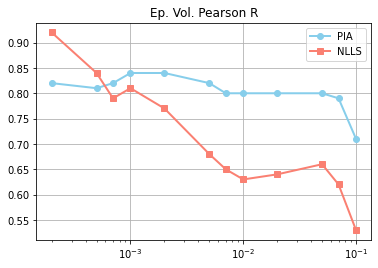

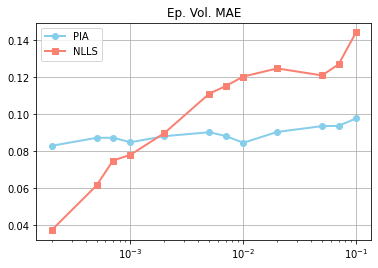

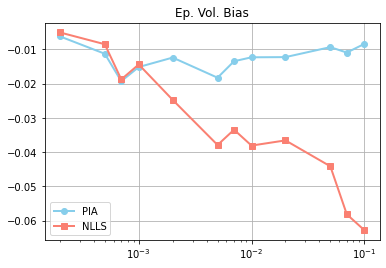

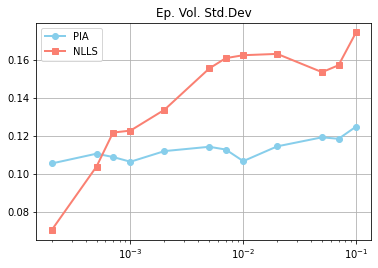

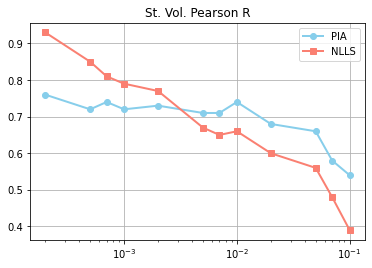

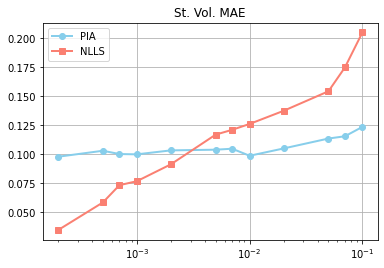

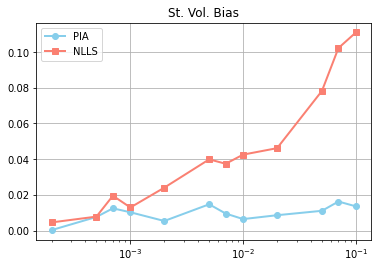

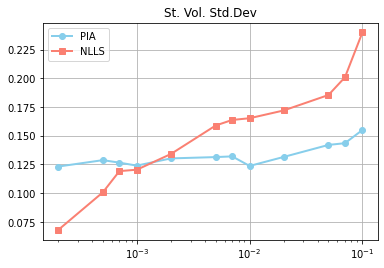

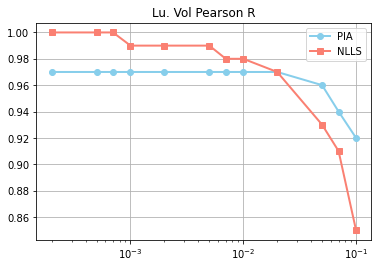

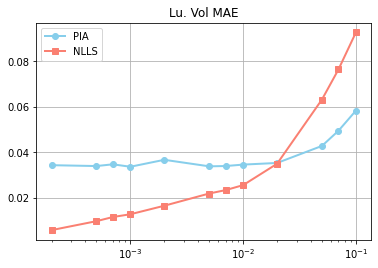

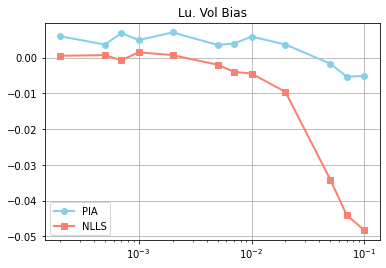

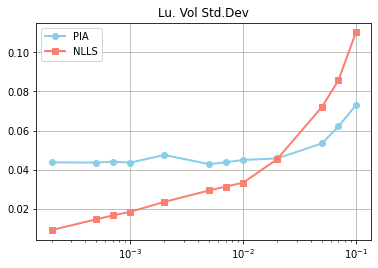

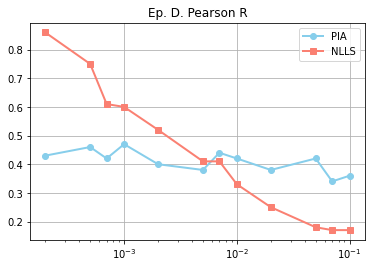

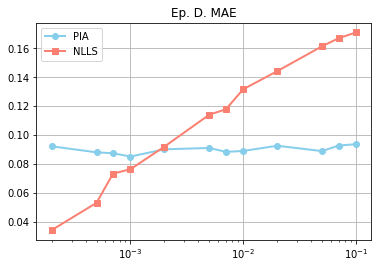

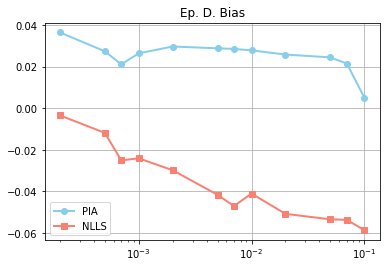

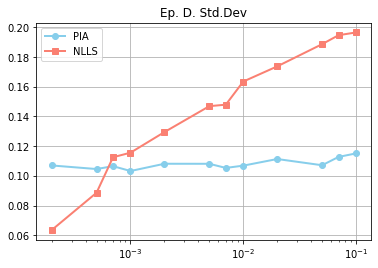

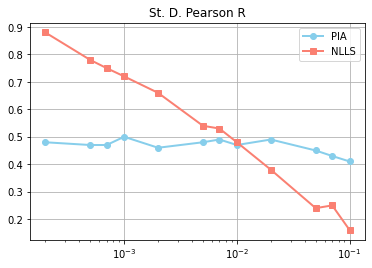

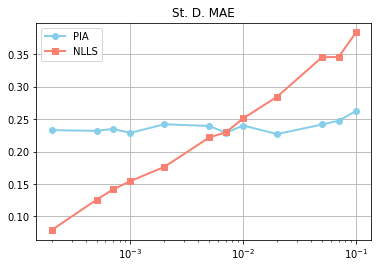

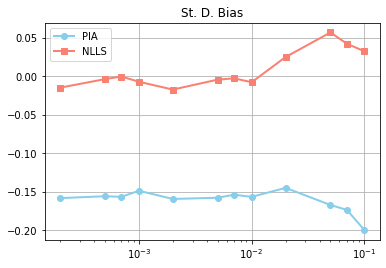

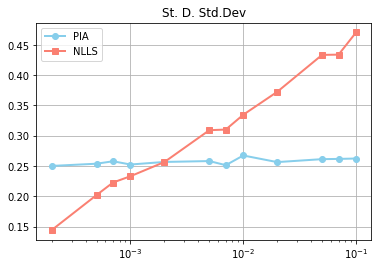

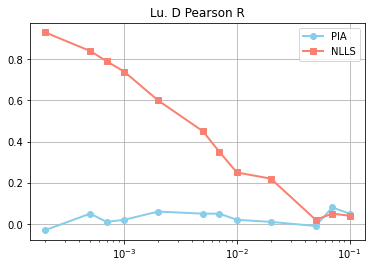

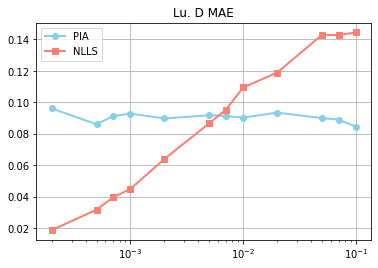

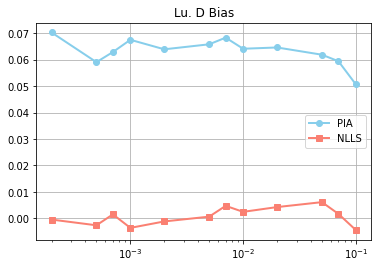

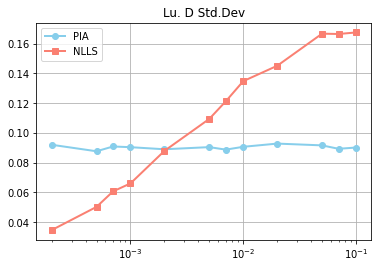

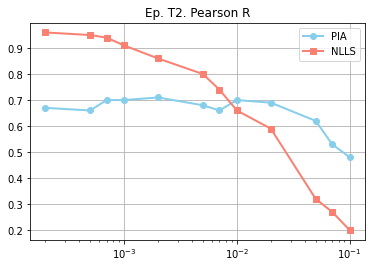

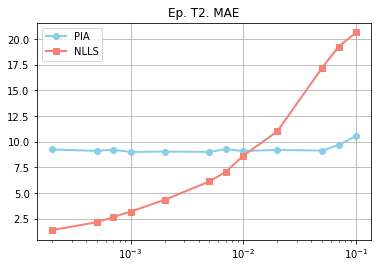

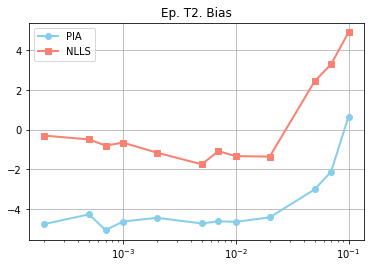

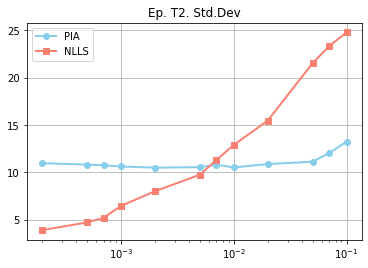

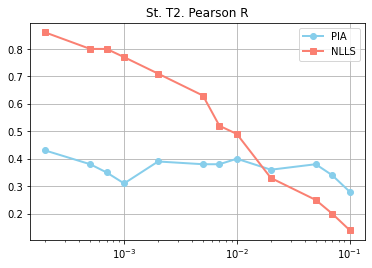

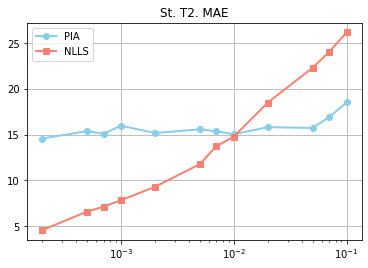

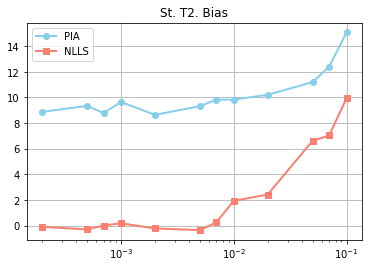

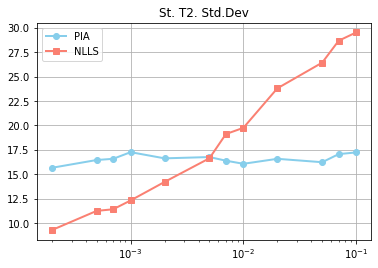

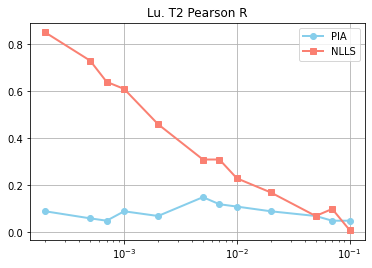

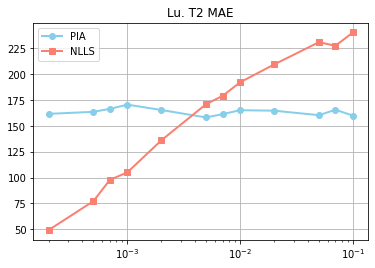

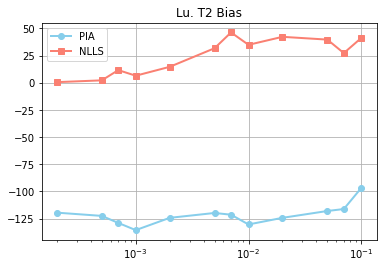

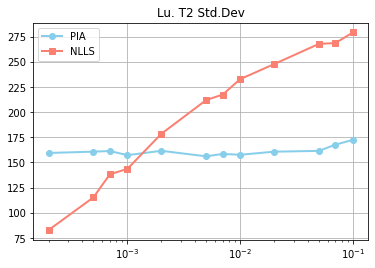

In [32]:
sequence_names = ['Ep. Vol.', 'St. Vol.', 'Lu. Vol' , 'Ep. D.', 'St. D.', 'Lu. D', 'Ep. T2.', 'St. T2.', 'Lu. T2']
measure_names = ['Pearson R', 'MAE', 'Bias', 'Std.Dev']
for name, sq in enumerate([v_ep, v_st, v_lu, D_ep, D_st, D_lu, T2_ep, T2_st, T2_lu]):
    for meas, kw in enumerate(['corr', 'mae', 'bias', 'std']):
        fig, ax = plt.subplots(1,1)
        P = [x[kw][0] for x in sq]
        H = [x[kw][1] for x in sq]
        line1 = ax.plot(noise_levels, P, color='skyblue', lw=2, marker='o', label='PIA')
        line2 = ax.plot(noise_levels, H, color='salmon', lw=2, marker='s', label ='NLLS')
        ax.set_xscale('log')
        ax.set_title(f'{sequence_names[name]} {measure_names[meas]}')
        ax.legend(['PIA', 'NLLS'])
        ax.grid(True)




In [61]:
from scipy import stats
def steigers_z_test(r1, r2, n1, n2):
    """
    Performs Steiger's Z-test for two dependent correlation coefficients sharing one variable in common.

    Args:
    r1 (float): Pearson correlation coefficient for the first comparison.
    r2 (float): Pearson correlation coefficient for the second comparison.
    n1 (int): Sample size for the first comparison.
    n2 (int): Sample size for the second comparison.

    Returns:
    float: Z-score indicating the difference between the two correlation coefficients.
    float: p-value assessing the significance of the Z-score.
    """
    # Fisher Z transformation for each correlation
    z1 = np.arctanh(r1)
    z2 = np.arctanh(r2)

    # Standard error for each transformed correlation
    se1 = 1 / np.sqrt(n1 - 3)
    se2 = 1 / np.sqrt(n2 - 3)

    # Standard error of the difference
    sed = np.sqrt(se1**2 + se2**2)

    # Z-score
    z = (z1 - z2) / sed

    # Two-tailed p-value
    p = 2 * (1 - stats.norm.cdf(np.abs(z)))

    return z, p

def calculate_mae_bias_variance(y_true, y_pred):
    """
    Calculate the Mean Absolute Error (MSE) and Bias.

    Args:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted or estimated values.

    """
    mae = np.mean(np.abs(y_true - y_pred))
    bias = np.mean((y_pred - y_true))
    variance = np.std((y_pred - y_true))**2

    return mae, bias, variance

def compare_mae(y_true, y_pred1, y_pred2):

    mae1, bias1, variance1 = calculate_mae_bias_variance(y_true, y_pred1)
    mae2, bias2, variance2 = calculate_mae_bias_variance(y_true, y_pred2)

    # Perform paired t-test
    _, p_value = stats.ttest_rel(np.abs(y_true - y_pred1), np.abs(y_true - y_pred2))
    _, p_value2 = stats.ttest_rel(y_true - y_pred1, y_true - y_pred2)

    # Calculate variances
    var_a = variance1**2
    var_b = variance2**2

    # Calculate F statistic
    F = var_a / var_b
    df1 = len(y_true) - 1  # degrees of freedom for sample 1
    df2 = len(y_true) - 1  # degrees of freedom for sample 2

    # Calculate p-value
    p_value3 = 1 - stats.f.cdf(F, df1, df2) if var_a > var_b else stats.f.cdf(F, df1, df2)

    return mae1, bias1, mae2, bias2, variance1, variance2, p_value, p_value2, p_value3

# def get_scores(test, pia, hybrid, inx):    
#     
#     y1 = pia[:, inx].detach().cpu().numpy()
#     corr1 = round(pearsonr(y1, x1)[0], 2)
#     mae1 = np.mean(np.abs(y1 - x1))
#     bias1 = np.mean((y1 - x1))
#     std1 = np.std((y1 - x1))
#     x2 = test.detach().cpu().numpy()[:, inx] 
#     
#     corr2 = round(pearsonr(y2, x2)[0], 2)
#     mae2 = np.mean(np.abs(y2 - x2))
#     bias2 = np.mean((y2 - x2))
#     std2 = np.std((y2 - x2))
#     return  (corr1, corr2), (mae1,mae2), (bias1,bias2), (std1,std2)





    
PATH = '/home/gundogdu/Desktop/PIA_Histology/pia_model.pt'
model = torch.load(PATH)
N = 0.02
B = 2500
_, D_test2, T2_test2, v_test, clean = get_batch(B, noise_sdt=0)
clean = clean.detach().cpu().numpy()
noise_im = np.random.normal(0, N, (B, 16))
noise_re = np.random.normal(0, N, (B, 16))
noisy = np.sqrt((clean + noise_im)**2 + (clean + noise_re)**2)/np.sqrt(2)

test_tensor = 1000*torch.from_numpy(noisy).float()
test_tensor = test_tensor.cuda()
D_pia, T2_pia, v_pia = model.encode(test_tensor)
test = test_tensor.detach().cpu().numpy()/1000
D_hybrid, T2_hybrid, v_hybrid = hybrid_fit(test)




100%|██████████| 2500/2500 [03:01<00:00, 13.77it/s]


In [62]:
for r in range(3):
    if r==0:
        x_image, y_image = v_test, v_hybrid
        title = ['V_ep', 'V st', 'V lu']
    elif r==1:
        x_image, y_image = D_test2, D_hybrid
        title = ['D ep', 'D st', 'D lu']
    elif r==2:
        x_image, y_image = T2_test2, T2_hybrid
        title = ['T2 ep', 'T2 st', 'T2 lu']
    for c in range(3):

        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c]

        corr = round(pearsonr(y, x)[0], 2)
        mae = np.mean(np.abs(y - x))
        bias = np.mean((y - x))
        std = np.std((y - x))
        print(f'{title[c]} {corr:.2f} {mae:.2f} {bias:.2f} {std:.2f}')
print('--------------------------')
for r in range(3):
    if r==0:
        x_image, y_image = v_test, v_pia
        title = ['V_ep', 'V st', 'V lu']
    elif r==1:
        x_image, y_image = D_test2, D_pia
        title = ['D ep', 'D st', 'D lu']
    elif r==2:
        x_image, y_image = T2_test2, T2_pia
        title = ['T2 ep', 'T2 st', 'T2 lu']
    for c in range(3):

        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c].detach().cpu().numpy()

        corr = round(pearsonr(y, x)[0], 2)
        mae = np.mean(np.abs(y - x))
        bias = np.mean((y - x))
        std = np.std((y - x))
        print(f'{title[c]} {corr:.2f} {mae:.2f} {bias:.2f} {std:.2f}')

V_ep 0.68 0.12 -0.04 0.15
V st 0.65 0.13 0.05 0.16
V lu 0.97 0.03 -0.01 0.04
D ep 0.29 0.14 -0.05 0.17
D st 0.40 0.28 0.03 0.36
D lu 0.15 0.12 0.00 0.15
T2 ep 0.56 11.28 -0.69 15.76
T2 st 0.43 17.03 2.40 22.02
T2 lu 0.09 218.15 45.50 256.60
--------------------------
V_ep 0.82 0.09 -0.01 0.11
V st 0.72 0.10 0.01 0.13
V lu 0.97 0.03 0.00 0.04
D ep 0.41 0.09 0.03 0.11
D st 0.49 0.23 -0.15 0.25
D lu 0.04 0.09 0.06 0.09
T2 ep 0.67 9.12 -4.23 10.87
T2 st 0.40 15.19 9.75 16.07
T2 lu 0.10 165.52 -124.57 160.85


In [74]:
def get_scores(test, pia, hybrid, inx, B):
    x1 = test[:,inx].detach().cpu().numpy()
    y1 = pia[:, inx].detach().cpu().numpy()
    y2 = hybrid[:, inx]
    r_pia = pearsonr(x1, y1)[0]
    r_hybrid = pearsonr(x1, y2)[0]
    mae_pia, bias_pia, mae_hybrid, bias_hybrid, var_pia, var_hybrid, p_value, p_value2, p_value3  = compare_mae(x1, y1, y2)
    print(f"Paired t-test on absolute error - p-value: {p_value:.4f}")
    print(f"Paired t-test on bias - p-value: {p_value2:.4f}")
    print(f"F-test on variances - p-value: {p_value3:.4f}")
    print(f'Steiger\'s z-test for correlation strenghths of PIA and Hybrid p = {steigers_z_test(r_hybrid, r_pia, B, B)[1]}')

get_scores(T2_test2, T2_pia, T2_hybrid, 2, B)


Paired t-test on absolute error - p-value: 0.0000
Paired t-test on bias - p-value: 0.0000
F-test on variances - p-value: 0.0000
Steiger's z-test for correlation strenghths of PIA and Hybrid p = 0.6699039297765712


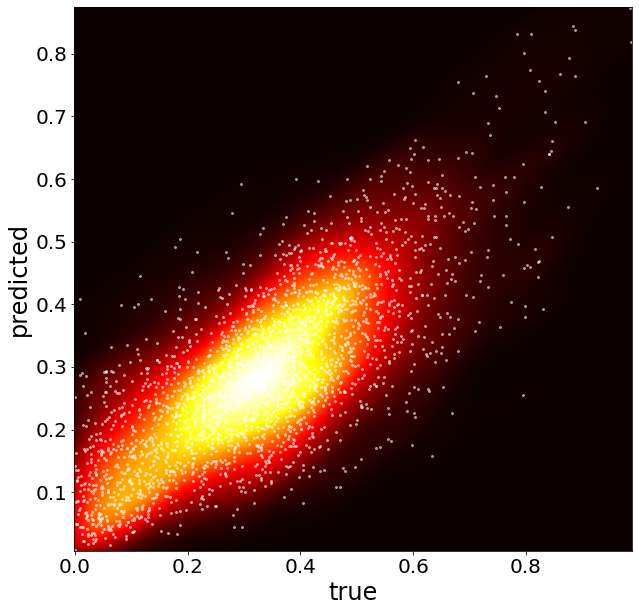

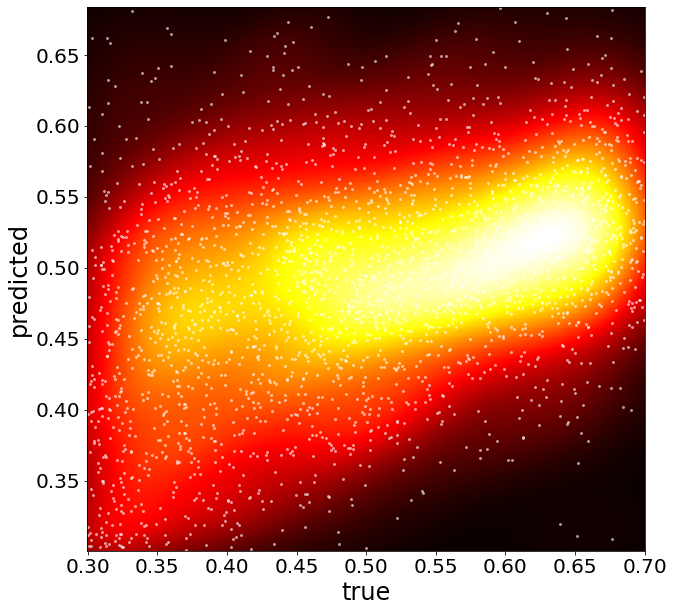

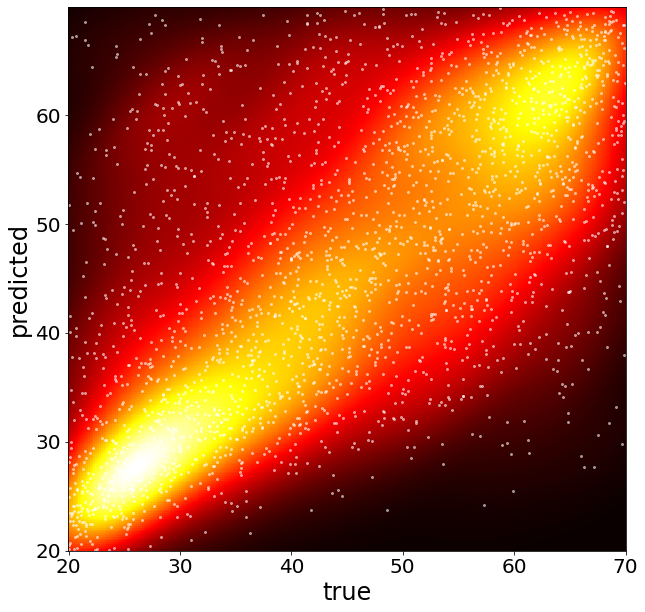

In [12]:
D, T2, v = model.encode(test_tensor)

for r in range(3):
    if r==0:
        x_image, y_image = v_test, v
        title = ['V_ep', 'V st', 'V lu']
        ylims = [(0,1), (0,1), (0,1)]
    elif r==1:
        x_image, y_image = D_test2, D
        title = ['D ep', 'D st', 'D lu']
        ylims = [(0.3, 0.7), (0.7, 1.7), (2.7, 3)]
    elif r==2:
        x_image, y_image = T2_test2, T2
        title = ['T2 ep', 'T2 st', 'T2 lu']
        ylims = [(20, 70), (40, 100), (500, 1000)]
    for c in range(1):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        x = x_image.detach().cpu().numpy()[:,c] 
        y = y_image[:, c].detach().cpu().numpy()
        nbins=300
        k = gaussian_kde([x,y])
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="hot", shading='auto')
        ax.scatter(x,y, color='white', s=4, alpha=0.5)

        #err = np.mean(np.abs(x_image.detach().cpu().numpy()[:,c]-y_image[:, c]))
        #corr = np.corrcoef(x_image.detach().cpu().numpy()[:,c],y_image[:, c])[0,1]
        ax.xaxis.set_tick_params(labelsize=20)
        ax.yaxis.set_tick_params(labelsize=20)
        #ax[r,c].set_title(fr'{title[c]}, MAE = {err:.3f}, $\rho$ = {corr:.3f}')
        ax.set_xlabel('true', fontsize=24)
        ax.set_ylabel('predicted', fontsize=24)


In [113]:
# Speed Analysis
test_tensor, D_test2, T2_test2, v_test, clean = get_batch(10000, noise_sdt=0.01)
test = test_tensor.detach().cpu().numpy()


In [114]:
start = time.time()
D, T2, v = hybrid_fit(test)
end = time.time()
print(f'Hybrid 1.0 takes {end - start} seconds')

100%|██████████| 10000/10000 [08:21<00:00, 19.96it/s] 

Hybrid 1.0 takes 501.03609895706177 seconds


In [119]:
model2 = PIA(predictor_depth=2).float()#.to('cpu')
test_tensor = test_tensor.to('cuda')




In [123]:
start = time.time()
D, T2, v = model2.encode(test_tensor) 
end = time.time()
print(f'Hybrid 2.0 takes {end - start} seconds')

Hybrid 2.0 takes 0.08289694786071777 seconds


In [124]:
502/0.08

6275.0

In [122]:
test_tensor

tensor([[1.4145, 1.2445, 0.6809,  ..., 0.2960, 0.0833, 0.0384],
        [1.4201, 1.2412, 0.7112,  ..., 0.3040, 0.0743, 0.0441],
        [1.4273, 1.2027, 0.5812,  ..., 0.1297, 0.0451, 0.0242],
        ...,
        [1.4188, 1.3121, 0.9213,  ..., 0.1452, 0.0431, 0.0341],
        [1.4226, 1.2124, 0.6472,  ..., 0.2936, 0.0804, 0.0292],
        [1.4282, 1.2576, 0.7303,  ..., 0.1961, 0.0563, 0.0433]],
       device='cuda:0')